# Part 0: Sample Selection

This is the first notebook for reproducing [Imig et al 2024](http://astronomy.nmsu.edu/jimig/Imig_MW_density.pdf). In this notebook, all of the figures and numbers presented as results in the paper are produced. 

This notebook contains Figures X-Y from the paper


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import astropy.io.fits as fits

# Sample Setup and helper functions
from mw_density import sample_selection, plotting_helpers

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib.collections import LineCollection

from scipy.spatial import ConvexHull
from scipy.interpolate import interpn

#Define Plotting Parameters
params = {'axes.labelsize': 36, 'xtick.labelsize': 36, 'ytick.labelsize': 36, 
          'text.usetex': False, 'lines.linewidth': 1,
          'axes.titlesize': 22, 'font.family': 'serif', 'font.size': 36}
plt.rcParams.update(params)

figure_directory='results/figures/'

In [2]:
age_bins, mh_bins = sample_selection.setup_maap_bins()
allstar = fits.open(sample_selection.get_allstar_filepath())[1].data
distmass = fits.open(sample_selection.get_distmass_filepath())[1].data
data_mask = sample_selection.get_data_mask(allstar, distmass)
low_alpha_mask, high_alpha_mask = sample_selection.get_alpha_masks(allstar[data_mask])

apogee_sample = fits.open('data/apogee_sample.fits')[1].data
logg_min_lim = np.min(apogee_sample['LOGG'])
logg_max_lim = np.max(apogee_sample['LOGG'])

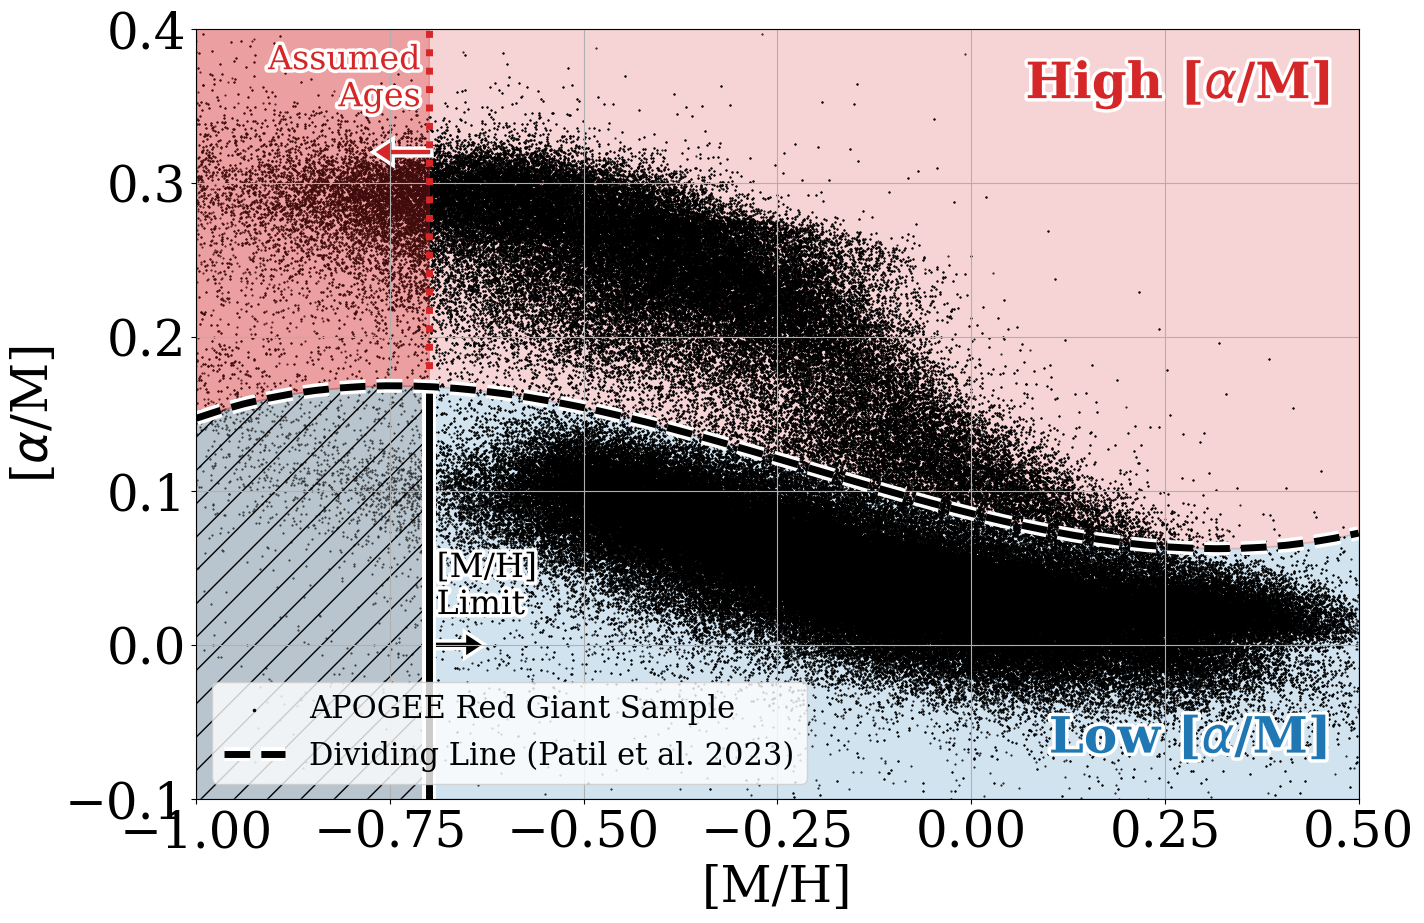

<Figure size 640x480 with 0 Axes>

In [3]:
plt.figure(figsize=(15,10))

f = np.linspace(-1,0.5)
halphaline = np.array([sample_selection.alpha_line_patil2023(i) for i in f])

plt.fill_between(f, np.ones(len(f))*-0.1, halphaline,color='tab:blue',alpha=0.2)
plt.fill_between(f, halphaline, np.ones(len(f))*4,color='tab:red',alpha=0.2)
#plt.fill_between(f, halphaline-0.025,halphaline+0.025,color='k',alpha=0.3)

tmp_m = (allstar['LOGG']<=logg_max_lim)&(allstar['LOGG']>=logg_min_lim)
tmp_m = tmp_m&(allstar['EXTRATARG'] == 0)
tmp_m = tmp_m&(allstar['ALPHA_M']>=-1.0)&(allstar['TEFF']<=5500)
tmp_m = tmp_m&((allstar['ASPCAPFLAG']&(2**23)) == 0) #STAR_BAD

plt.scatter(allstar['M_H'][tmp_m],allstar['ALPHA_M'][tmp_m],
            s=1,marker='.',c='k')

plt.scatter(allstar['M_H'][data_mask],allstar['ALPHA_M'][data_mask],
            s=1,marker='.',c='k')
plt.scatter([-10],[0],
            s=10,marker='.',c='k',label='APOGEE Red Giant Sample')
plt.xlim(-1.0,0.5)
plt.ylim(-0.1,0.4)

#plt.plot(f,halphaline+0.025,c='tab:red',lw=5)
#plt.plot(f,halphaline-0.025,c='tab:blue',lw=5)


#plt.colorbar()
plt.grid()
plt.xlabel('[M/H]',fontsize=36)
plt.ylabel(r'[$\alpha$/M]',fontsize=36)
txt1=plt.text(0.07,0.355, r'High [$\alpha$/M]',weight='bold',color='tab:red',fontsize=36)
txt1.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
txt2=plt.text(0.1,-0.07, r'Low [$\alpha$/M]',weight='bold',color='tab:blue',fontsize=36)
txt2.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

#metallicity limit
min_feh = np.min(allstar['M_H'][data_mask][low_alpha_mask])
plt.plot([min_feh, min_feh], [-0.1, sample_selection.alpha_line_patil2023(min_feh)],color='k',lw=5,
         path_effects=[PathEffects.withStroke(linewidth=10, foreground='w')])
plt.arrow(min_feh, 0, 0.05, 0, lw=7,color='w',head_width=0.01)
plt.arrow(min_feh, 0, 0.05, 0, lw=2,color='k',head_width=0.01)
txt1=plt.text(min_feh+0.01,0.02, '[M/H] \nLimit',color='k',fontsize=24)
txt1.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

x = np.linspace(-1,min_feh,10)
plt.fill_between(x, np.ones(len(x))*-0.1,
                 sample_selection.alpha_line_patil2023(x),hatch='/',facecolor='gray', alpha=0.3)


# alpha age assumptions
plt.plot([min_feh, min_feh], [sample_selection.alpha_line_patil2023(min_feh),0.4], ':', color='tab:red',lw=5)
txt1=plt.text(min_feh-0.01,0.39, 'Assumed\nAges',color='tab:red',fontsize=24, ha='right',va='top')
txt1.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
x = np.linspace(-1,min_feh,10)
plt.fill_between(x, sample_selection.alpha_line_patil2023(x), np.ones(len(x))*0.5, color='tab:red', alpha=0.3)
plt.arrow(min_feh, 0.32, -0.05, 0, lw=7,color='w',head_width=0.01)
plt.arrow(min_feh, 0.32, -0.05, 0, lw=2,color='tab:red',head_width=0.01)



plt.plot(f,halphaline,'--',c='k',lw=5,
         path_effects=[PathEffects.withStroke(linewidth=10, foreground='w')], label='Dividing Line (Patil et al. 2023)')


#plt.scatter(apogee_sample['M_H'][high_alpha_mask], apogee_sample['ALPHA_M'][high_alpha_mask],
#           c='tab:red')
#
#plt.scatter(apogee_sample['M_H'][low_alpha_mask], apogee_sample['ALPHA_M'][low_alpha_mask],
#           c='tab:blue')


#plt.axvspan(-1,min_feh,hatch='/',alpha=0.0)
plt.legend(loc='lower left',fontsize=22)
plt.savefig(figure_directory + 'alpha_cuts.png',bbox_inches='tight')
plt.show()
plt.clf()

In [4]:
ncount_distmass_HIGH=np.zeros((len(age_bins["center"]),len(mh_bins["center"])))
ncount_distmass_LOW=np.zeros((len(age_bins["center"]),len(mh_bins["center"])))

tot = len(age_bins["center"])*len(mh_bins["center"])

cnter=0
for i in range(len(age_bins["center"])):
    for j in range(len(mh_bins["center"])):
        bin_mask = (apogee_sample['AGE_BIN_I'] == i)&(apogee_sample['METAL_BIN_I'] == j)
        low_bmask = bin_mask&(apogee_sample['ALPHA_BIN']=='LOW')
        high_bmask = bin_mask&(apogee_sample['ALPHA_BIN']=='HIGH')
        ncount_distmass_LOW[i,j] = len(low_bmask[low_bmask])
        ncount_distmass_HIGH[i,j] = len(high_bmask[high_bmask])
        
        cnter+=1
        #print('{}/{}'.format(cnter,tot))

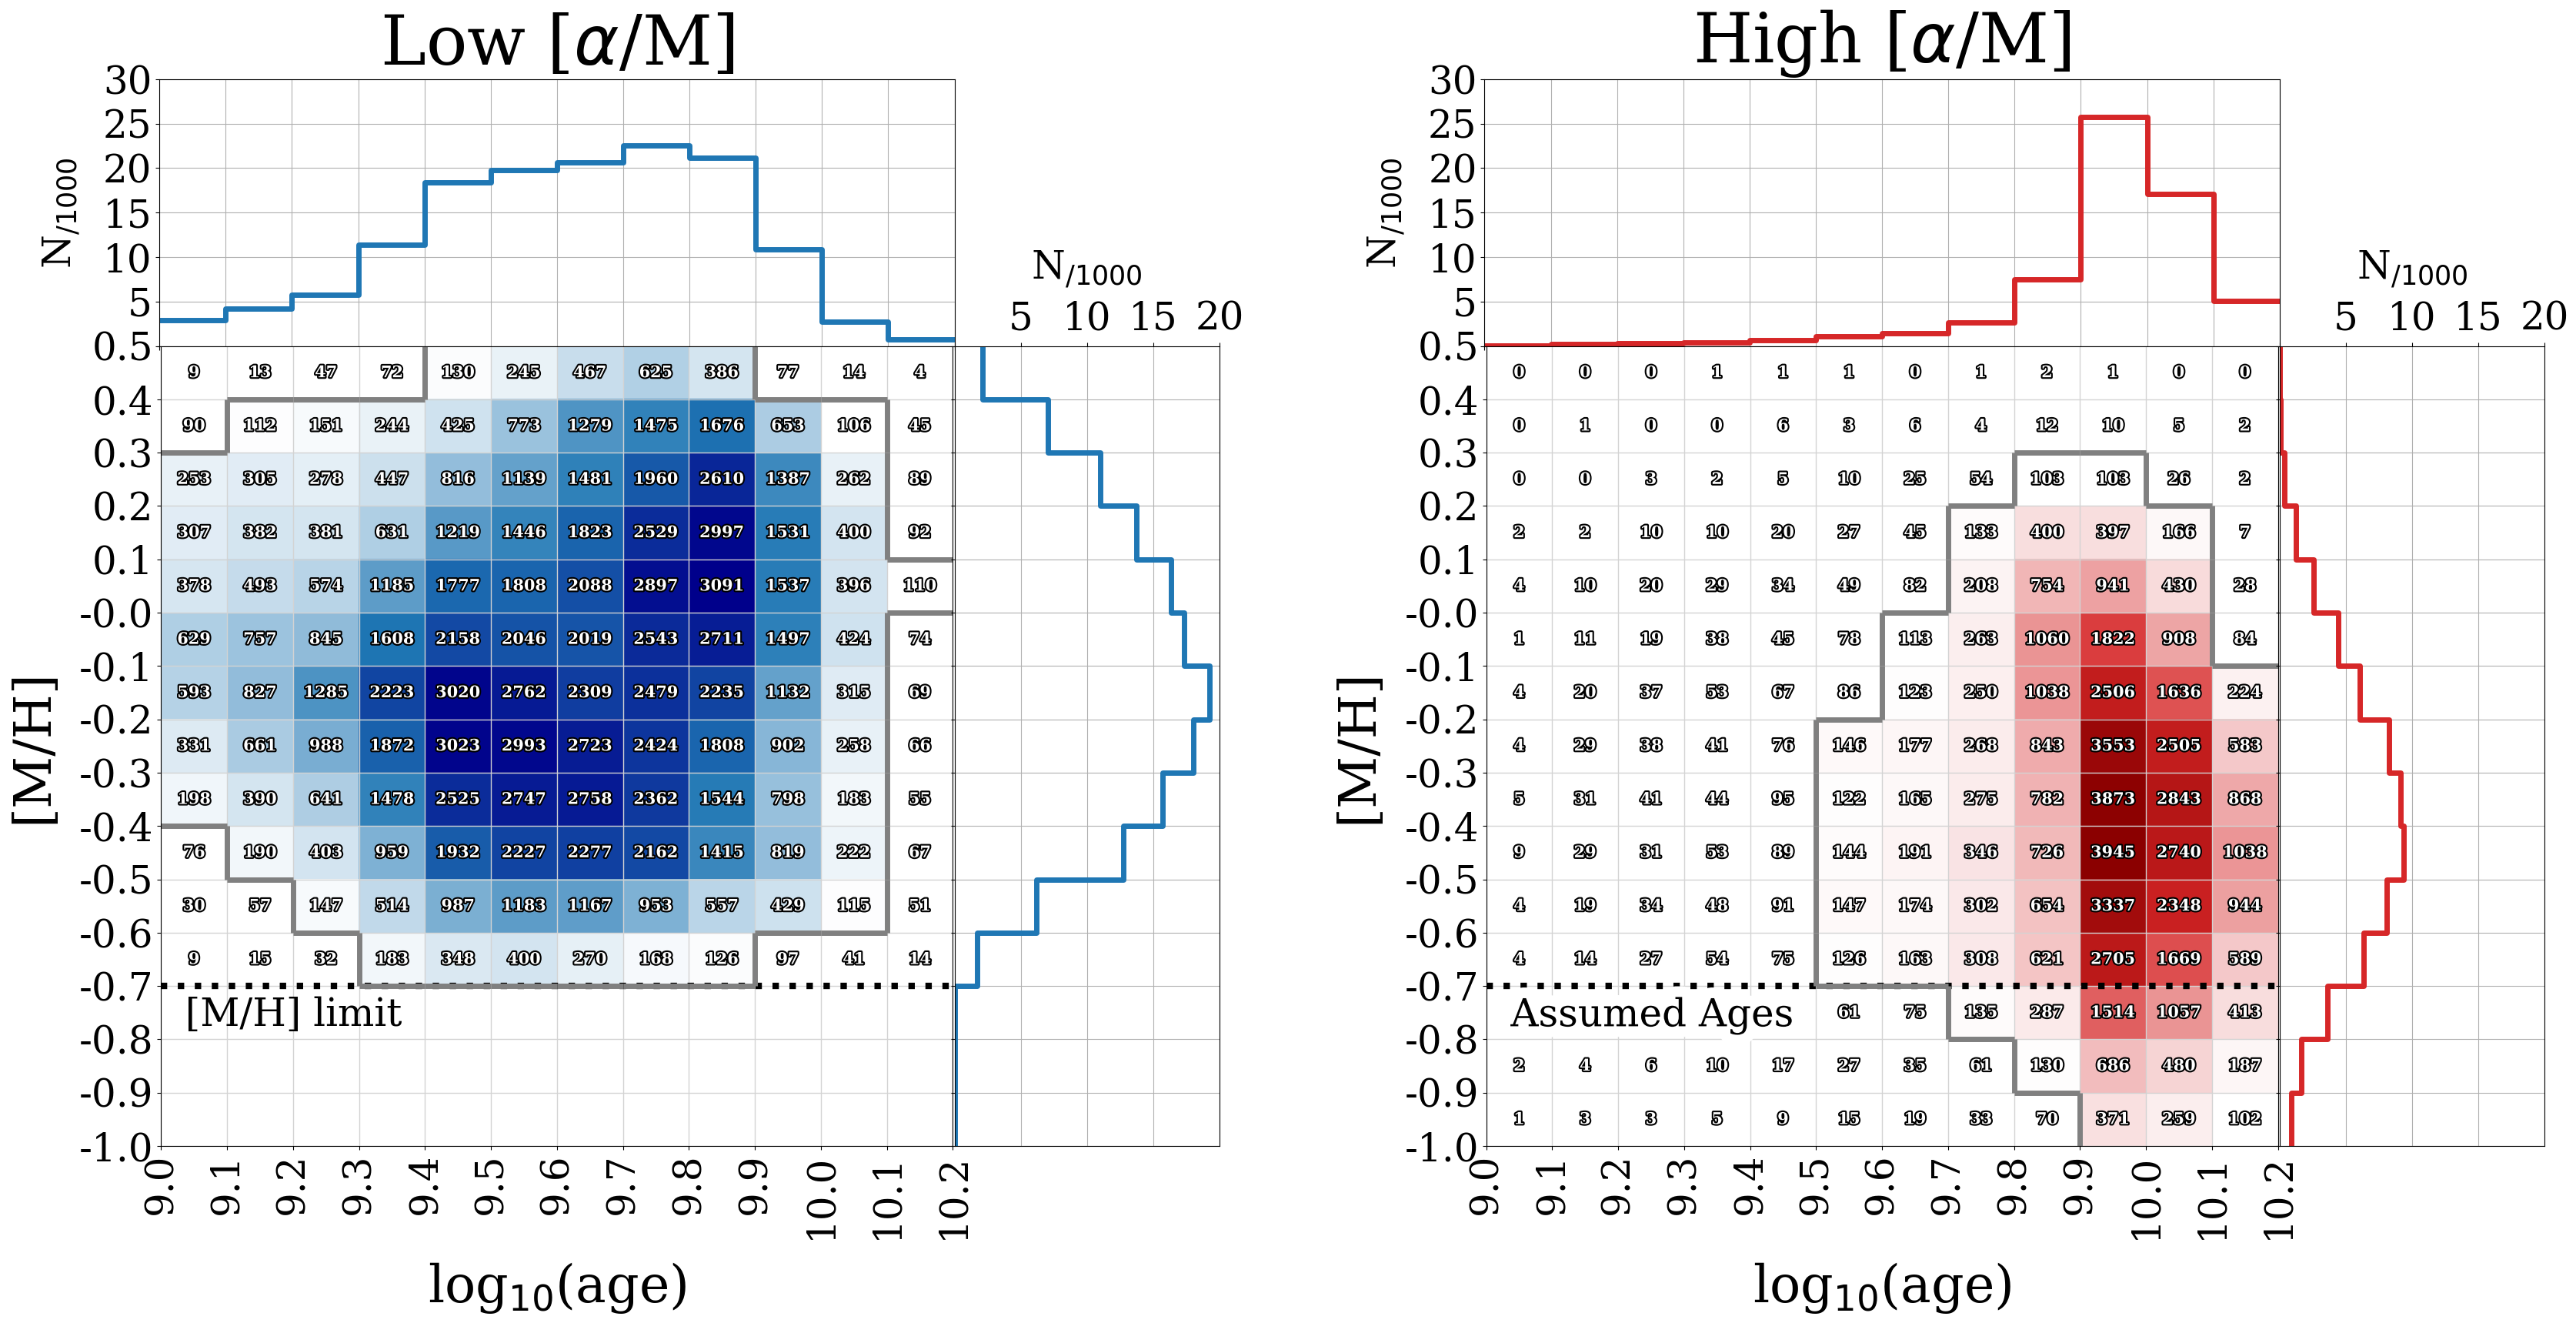

203197.0


In [5]:
plotting_helpers.bin_count_plot_histo(ncount_distmass_LOW,ncount_distmass_HIGH,
                                      savename = figure_directory + 'bincounts.png')

print(np.sum(ncount_distmass_LOW)+np.sum(ncount_distmass_HIGH))

/Users/jimig/research/mw_density_imig2024/mw_density/plotting_helpers.py:110: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/Users/jimig/research/mw_density_imig2024/mw_density/plotting_helpers.py:122: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/var/folders/pt/4pxym4x563d4rqpwzshf5dkh0001rb/T/ipykernel_54495/652923950.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(['','-10','-5','0',5,10,15])
/var/folders/pt/4pxym4x563d4rqpwzshf5dkh0001rb/T/ipykernel_54495/652923950.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_

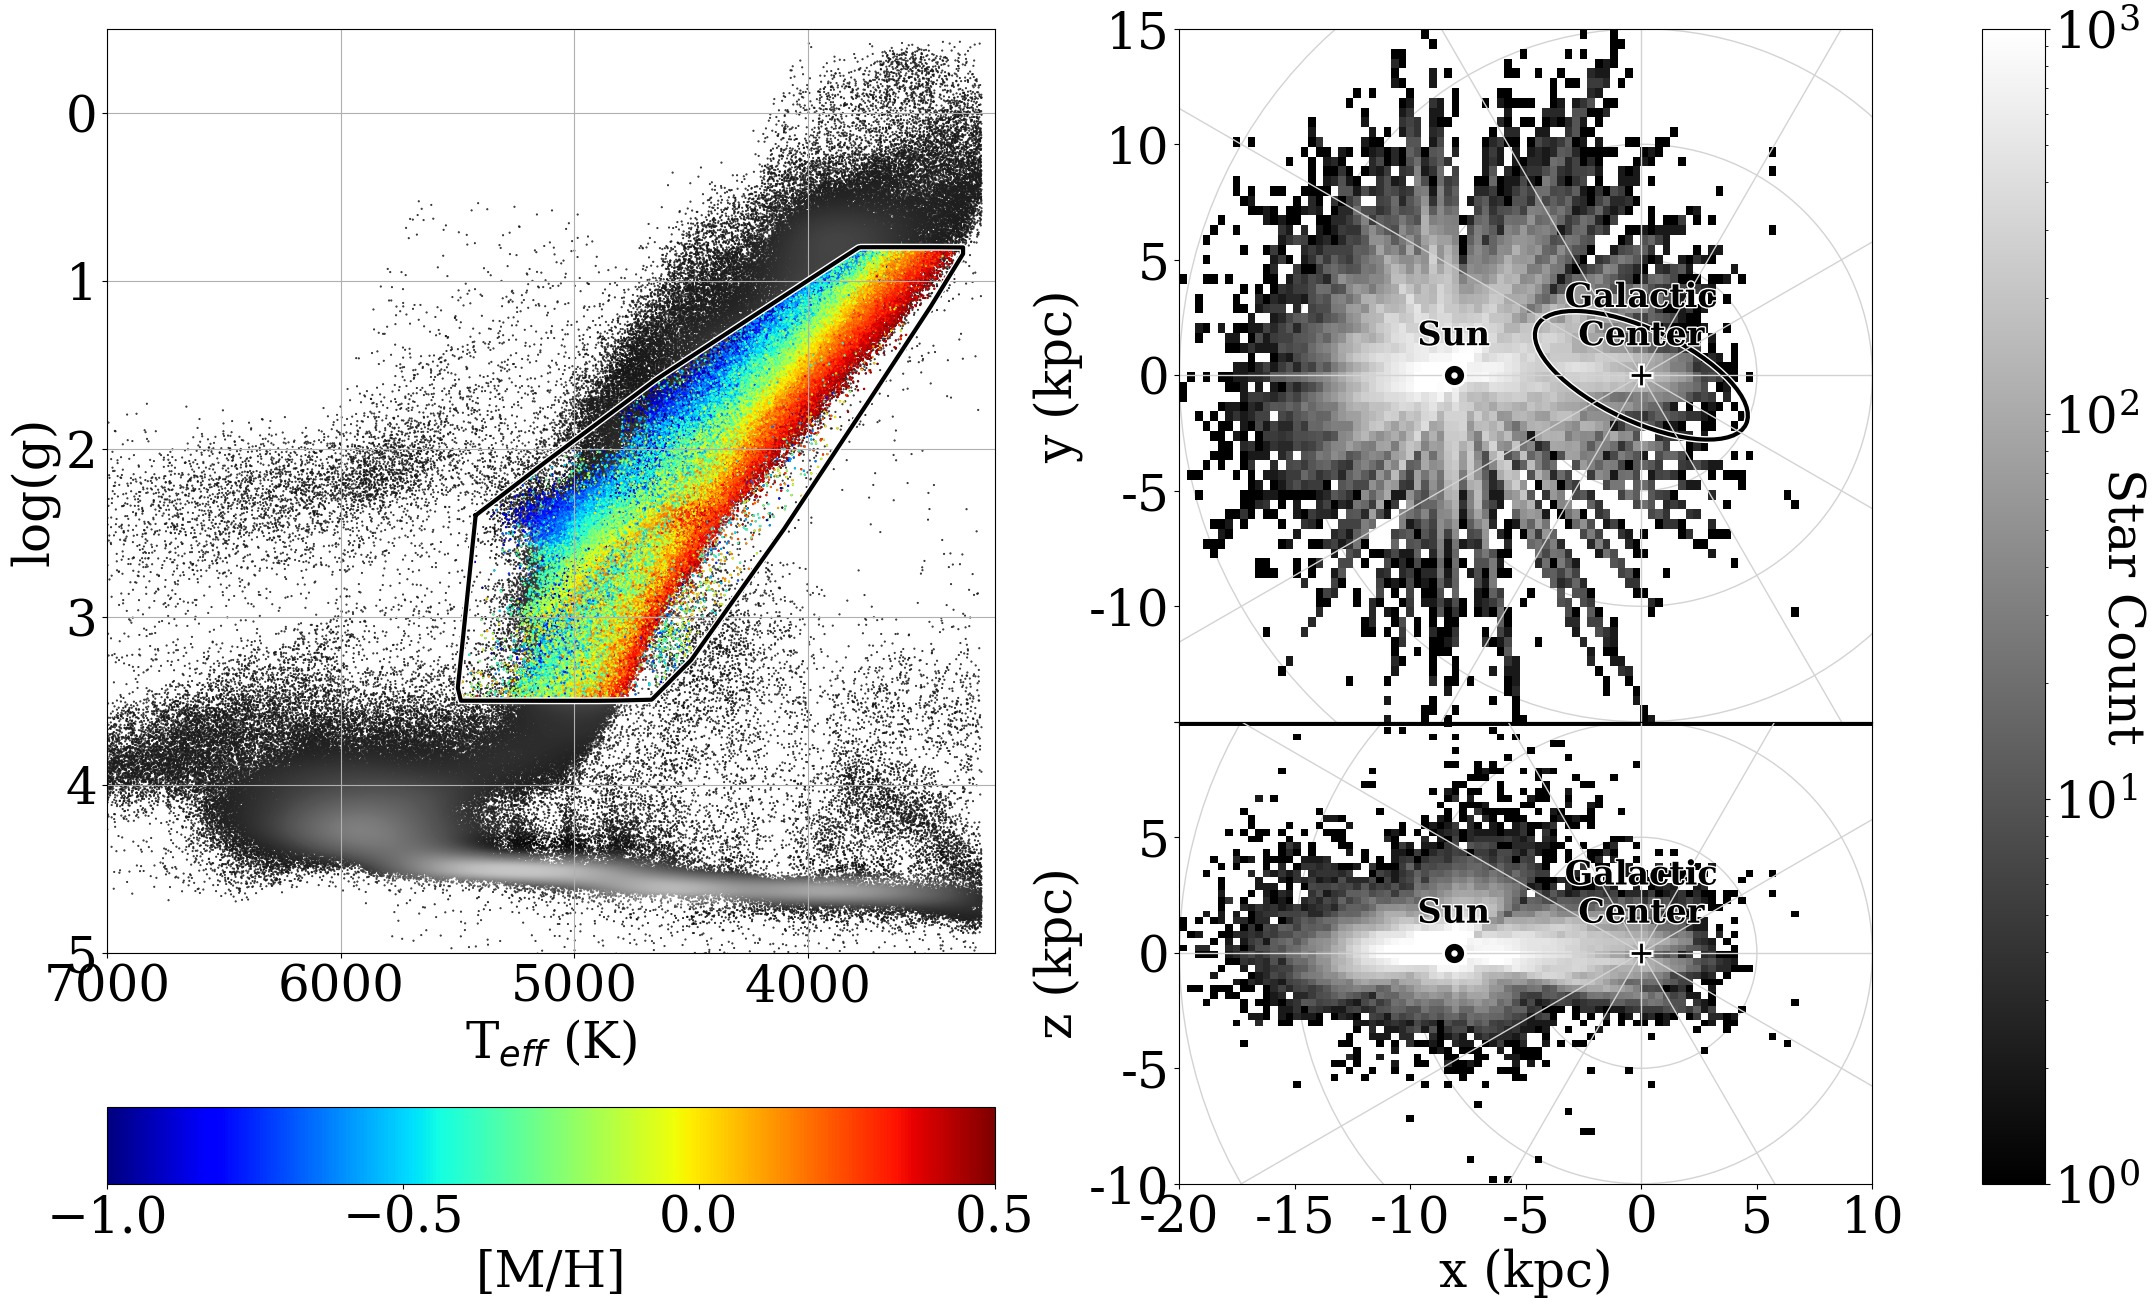

In [6]:
hull = ConvexHull(np.array([apogee_sample['TEFF'],apogee_sample['LOGG']]).T)
hull_x,hull_y = hull.points[hull.vertices].T

plt.figure(figsize=(25, 15))
ax_ratio = (15,13)

ax0 = plt.subplot2grid((15, 26), (0, 0), colspan=ax_ratio[1]-1,rowspan=ax_ratio[0]-3) #HR diagram
cax0 = plt.subplot2grid((15, 26), (ax_ratio[0]-1, 0), colspan=ax_ratio[1]-1,rowspan=1) #[M/H] colorbar


ax1 = plt.subplot2grid((15,26), (0, 13), colspan=ax_ratio[1]-1, rowspan=9) #face-on counts
plotting_helpers.plot_sun_and_GC(ax=ax1)

ax2 = plt.subplot2grid((15,26), (ax_ratio[0]-6, 13), colspan=ax_ratio[1]-1, rowspan=6) #edge-on counts
plotting_helpers.plot_sun_and_GC(ax=ax2,labels='False')

ax_c = plt.subplot2grid((15,26), (0, 25), colspan=1,rowspan=ax_ratio[0]) #Star count colorbar



for r in [5,10,15,20]:
    circgrid = plt.Circle((0, 0), r, facecolor='None',edgecolor='lightgray')
    ax1.add_patch(circgrid)
    circgrid = plt.Circle((0, 0), r, facecolor='None',edgecolor='lightgray')
    ax2.add_patch(circgrid)

im=ax1.hist2d(apogee_sample['GALACTIC_X'],apogee_sample['GALACTIC_Y'],cmap='gray',bins=100,norm=LogNorm(1,1e3))
cbar = plt.colorbar(im[3],cax=ax_c,label='N stars')
cbar.set_label(label='Star Count',rotation=-90)

ax2.hist2d(apogee_sample['GALACTIC_X'],apogee_sample['GALACTIC_Z'],cmap='gray',bins=100,norm=LogNorm(1,1e3))

ax1.set_ylabel('y (kpc)')
ax2.set_ylabel('z (kpc)')
ax2.set_xlabel('x (kpc)')

ax1.set_ylim(-15,15)
ax2.set_ylim(-5,5)
ax2.axhline(10,c='k',lw=5)
ax2.set_yticks([-10,-5,0,5,10])
ax2.set_yticklabels(['-10','-5',0,5,''])
ax1.set_yticklabels(['','-10','-5','0',5,10,15])
ax1.set_xticklabels('')
    
for ax in [ax1,ax2]:
    ax.set_xlim(-20,10)
    ax.set_xticks([-20,-15,-10,-5,0,5,10])
    ax2.set_xticklabels([-20,-15,-10,-5,0,5,10])
    #ax.grid()
    ax.set_aspect('equal')
    for m in np.arange(0,180,30):
        linx = np.linspace(-20,20,100)
        ax.plot(linx,np.tan(np.deg2rad(m))*linx,c='lightgray')


Gbar = mpl.patches.Ellipse([0,0], 10.0, 0.4*10.0, angle=-25,facecolor='None',edgecolor='w',lw=5)
ax1.add_patch(Gbar)
Gbar = mpl.patches.Ellipse([0,0], 10.0, 0.4*10.0, angle=-25,facecolor='None',edgecolor='k',lw=3)
ax1.add_patch(Gbar)
#ax1.set_title('Spatial Distribution')

#HR Diagram
#plt.scatter(allstar['TEFF'], allstar['LOGG'], s=1,marker='.',c='gray')

ax0.set_xlim(7000,3200)
ax0.set_ylim(5,-0.5)

alph_x = allstar['TEFF'][allstar['TEFF']>3000]
alph_y = allstar['LOGG'][allstar['TEFF']>3000]
data , x_e, y_e = np.histogram2d(alph_x, alph_y, bins = 50, density = True)
alph_z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ),
                 data , np.vstack([alph_x,alph_y]).T , method = "splinef2d", bounds_error = False)
idx = alph_z.argsort()
alph_x, alph_y, alph_z = alph_x[idx], alph_y[idx], alph_z[idx]
ax0.scatter(alph_x,alph_y,c=alph_z,s=1,marker='.',cmap='Greys_r')
im = ax0.scatter(apogee_sample['TEFF'],allstar['LOGG'][data_mask],
            s=2,marker='.',c=apogee_sample['M_H'],cmap='jet',vmin=-1.0,vmax=0.5)

plt.colorbar(im,cax=cax0,orientation='horizontal',label='[M/H]')

tmax = np.max(apogee_sample['TEFF'])
tmin = np.min(apogee_sample['TEFF'])
lmin = np.min(apogee_sample['LOGG'])
lmax = np.max(apogee_sample['LOGG'])
#ax0.plot([tmin,tmin,tmax,tmax,tmin],[lmax,lmin,lmin,lmax,lmax],c='k',lw=3)
ax0.plot(np.append(hull_x,hull_x[0]),np.append(hull_y,hull_y[0]),c='w',lw=5)
ax0.plot(np.append(hull_x,hull_x[0]),np.append(hull_y,hull_y[0]),c='k',lw=3)

ax0.grid()
ax0.set_ylabel('log(g)')
ax0.set_xlabel(r'T$_{eff}$ (K)')
#ax0.set_title('Kiel Diagram')

#plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(figure_directory + 'data_sample.png',bbox_inches='tight')

plt.show()
